# Bass模型

In [4]:
%matplotlib inline
from random import random
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 解决图像中的中文乱码问题

## 1. Bass模型
- 假定潜在市场中的消费者受两种力量驱使采纳某一创新：
 - 自身的创新意识，用创新系数p表示
 - 邻居影响，用模仿系数q表示

假定潜在市场中顾客数量为m，初始时刻采纳人数为0，在t时刻，采纳人数为n(t)，未采纳消费者的采纳概率为:

$$p+q\cdot \frac{n(t)}{m}$$

则在t时刻的采纳人数增长可表示为：

$$\frac{dn(t)}{dt} = \left(m-n(t)\right)\cdot \left(p+q\cdot \frac{n(t)}{m}\right)$$

解微分方程，并结合n(t=0)=0并可以求得：

$$n(t)=m\cdot \frac{1-e^{(p+q)\cdot t}}{1+\frac{q}{p}\cdot e^{(p+q)\cdot t}}$$

Bass模型常用来预测新产品在市场中的增长，大量论文基于Bass模型进行扩展，比如加入市场决策变量、考虑季节影响、考虑产品的更新迭代等。这篇论文(`Bass, 1969`)于2004年被评定为`Management Science`期刊过去50年中最具影响力的论文之一(`Bass, 2004`)。

经典的Bass(1969)模型假定潜在市场是一个**全连通的网络**，即一个未采纳创新的个体会受到所有市场中已采纳个体的影响。显然，这个假设是不合适的。大量研究表明，社会网络具有一些典型的结构特征，例如度分布的无标度性，小世界性和社团结构等。本项目主要目标如下：
- 构建网络版Bass模型
- 分析种子节点平均邻居数量对扩散过程的影响，例如：何时达到峰值采纳率、峰值采纳率是多少等

In [3]:
def bass_func(p, q, m, T):
    '''
    p: 创新系数
    q: 模仿系数
    m: 潜在市场中的顾客数量
    T: 扩散总周期
    '''
    t_list = np.arange(1, T + 1)
    a = 1 - np.exp(-(p + q) * t_list)
    b = 1 + q / p * np.exp(-(p + q) * t_list)
    diffu_cont = m * a / b
    adopt_cont = np.array(
        [diffu_cont[i] if i == 0 else diffu_cont[i] - diffu_cont[i - 1] for i in range(T)]
    )
    return adopt_cont

[1.22870605e+01 1.82923710e+01 2.71919144e+01 4.03311292e+01
 5.96216862e+01 8.77093490e+01 1.28105885e+02 1.85159100e+02
 2.63611230e+02 3.67347374e+02 4.96908152e+02 6.45798318e+02
 7.97011759e+02 9.23178762e+02 9.93928915e+02 9.89311524e+02
 9.10691704e+02 7.79960280e+02 6.27766687e+02 4.80487946e+02
 3.53794946e+02 2.53149206e+02 1.77443971e+02 1.22591411e+02
 8.38506420e+01 5.69601367e+01 3.85130516e+01 2.59580927e+01
 1.74587188e+01 1.17254479e+01 7.86734737e+00 5.27529288e+00
 3.53570997e+00 2.36908448e+00 1.58708408e+00 1.06307204e+00
 7.12012346e-01 4.76855667e-01 3.19351792e-01 2.13865322e-01]


Text(0, 0.5, 'Number of adopters')

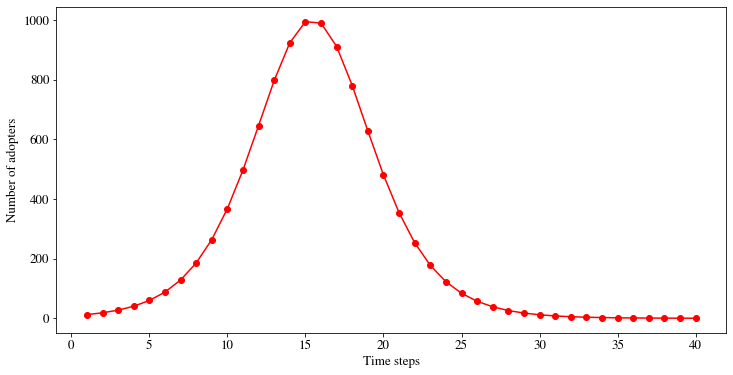

In [5]:
p, q, m, T = 0.001, 0.4, 10000, 40
adopt_cont = bass_func(p, q, m, T)
print(adopt_cont)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(1, T + 1), adopt_cont, 'ro-')
ax.set_xlabel("Time steps")
ax.set_ylabel("Number of adopters")

## 2. 基于Bass决策规则的智能体模型

将潜在市场抽象为一个固定社会网络，其中节点对应于消费者，边对应于消费者之间的关系。

对于网络中的节点，设定以下属性：
- 采纳状态state，取值为False时表示未采纳创新，为True时表示已采纳创新
- 所有影响的节点集合prede，取值为对该节点产生影响的其它所有节点的集合

节点的状态更新规则如下：
- 计算当前阶段未采纳创新节点i的采纳概率$\mathrm{prob_i}$：$1-(1-p_i)(1-q_i)^{\#adoptedPredecessors_i}$。
> 不采纳的概率为$(1-p)(1-q)^{\#adoptedPredecessors_i}$
- **模拟按照概率采纳创新**：通过均匀分布u(0,1)随机产生一个数rand，如果$\mathrm{prob_i\geq rand}$，则节点i的状态由Fasle更新为True。

> 随机更新规则
>
> - 可看成一次随机试验
> - 如果$x～U(0,1)$，则有$P\{\mathrm{x} <= \mathrm{prob}\} = \mathrm{prob}$

In [8]:
prob = 0.7
s_list = []
n = 10000
for i in range(n):
    if np.random.random() <= prob:  # 模拟以概率prob将数字1添加到s_list中
        s_list.append(1)
        
print(f'{n}次实验中，一共有{np.sum(s_list)}个1加入到s_list', )

10000次实验中，一共有6994个1加入到s_list


### 多智能体模型

- 输入: 创新系数均值p, 模仿系数均值q, 网络g, 扩散周期T
- 输出: 各周期对应的采纳者数量
- 算法过程:
    - 初始化节点属性和参数: 节点的前继集合prede_i, 节点的创新系数p_i, 节点的模仿系数q_i, 节点的采纳状态state_i, 当前时间步为t=0, 采纳者数量列表num_adopters_list=[]
    - 如果$t<T$, 则进行以下循环；否则，跳出循环
        - 初始化该周期的采纳者数量num_adopters=0
        - 对于网络中的所有节点，首先判断其采纳状态，如果state_i=False，则计算$prob_i = 1 - (1-p_i)(1-q_i)^{num_adopted_predes}$, 并将其与从服从U[0, 1]均匀分布随机变量中产生一个值r进行比较：如果prob_i > r, 则置state_i:=True, 且num_adopters:=num_adopters+1
        - 更新时间步t := t+1, 将num添加至num_adopters_list末尾

In [ ]:
  #构造无向ER网络nx.gnm_random_graph
    # 1）self只有在类的方法中才会有，独立的函数或方法是不必带有self的。

    # 2）self在定义类的方法时是必须有的，虽然在调用时不必传入相应的参数。

    # 3）self名称不是必须的，在python中self不是关键词，定义成a或b或其他名字都可以，只是约定俗成我们定义成了self。

    # 4）self指的是类实例对象本身，不是类本身。

In [8]:
class Agent_based_diffuse:  # 默认网络结构为节点数量为10000，边为30000的随机网络
    def __init__(self, p, q, g=nx.gnm_random_graph(1000, 3000), num_runs=35):
      
        '''
        p: 创新系数
        q: 模仿系数
        g: 网络, 可以替换成其它网络
        num_runs: 仿真时间步
        '''
        self.g = g.to_directed() if not nx.is_directed(g) else g  # 如果为无向网络，转换为有向网络
        self.num_runs = num_runs
        for i in self.g:  # 初始化节点属性
            self.g.nodes[i]['prede'] = list(self.g.predecessors(i))  # 节点i的前继邻居列表
            self.g.nodes[i]['p'] = p*(1 + np.random.randn())  # 随机设置p
            self.g.nodes[i]['q'] = q*(1 + np.random.randn())  # 随机设置q

    def decide(self, i):
        '''
        节点i决定是否采纳：已采纳的邻居数量、p、q
        返回：True 或 False
        '''
        num_adopt_prede = np.sum([self.g.nodes[k]['state'] for k in self.g.nodes[i]['prede']]) 
        #已采纳的邻居数量
        # i的处于采纳状态的邻居数量
        prob = 1 - (1 - self.g.nodes[i]['p'])*(1 - self.g.nodes[i]['q'])**num_adopt_prede  # 采纳概率
        return prob > np.random.random()

    def diffuse(self):
        '''
        一次模拟过程
        返回: 各轮的采纳者数量
        '''
        for i in self.g:  # 初始化节点状态
            self.g.nodes[i]['state'] = False
           
        num_of_adopters = []  # 记录每个时间步的采纳者数量
        for i in range(self.num_runs):
            num = 0  # 记录每一决策周期的采纳者数量
            for i in self.g:
                # 如果i未采纳，则进行决策：如果决定采纳，则更新状态且采纳者数量+1
                if self.g.nodes[i]['state'] == False and self.decide(i):
                    num += 1
                    self.g.nodes[i]['state'] = True

            num_of_adopters.append(num)

        return num_of_adopters

    def multi_diffuse(self, num_repetes=10):  # 多次扩散
        '''
        重复repetes次模型
        '''
        adopt_cont = []
        for i in range(num_repetes):
            d = self.diffuse()
            adopt_cont.append(d)
            
        return adopt_cont

In [11]:
t1 = time.perf_counter()
p, q = 0.001, 0.08
abm = Agent_based_diffuse(p, q)
diffu_cont = abm.multi_diffuse()

print(f"参数设置: p--{p}, q--{q} network--{abm.g.number_of_nodes()}")
print(f"用时{time.perf_counter() - t1:.2f}秒")

参数设置: p--0.001, q--0.08 network--1000
用时13.45秒


Text(0, 0.5, 'Number of adopters')

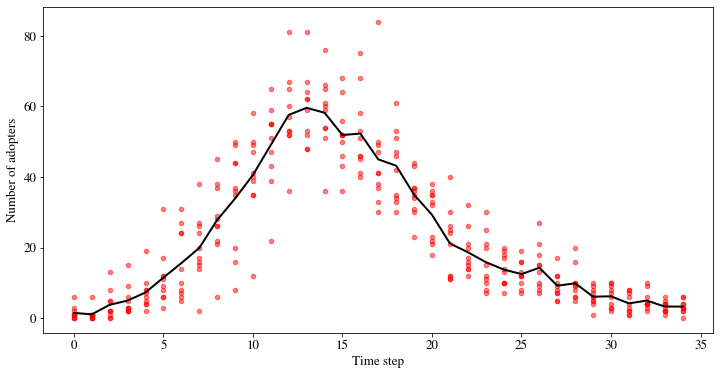

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for line in diffu_cont:
    ax.scatter(np.arange(abm.num_runs), line, color='red', s=20, alpha=0.5)
    
ax.plot(np.mean(diffu_cont, axis=0), 'k-', lw=2)
ax.set_xlabel('Time step')
ax.set_ylabel('Number of adopters')